# Main characteristics of SEM

Two main novel ideas compared to classic multivariate regression:

- Path analysis: model non-causal as well as causal relationships
- Latent variables: model unmeasurable concepts (e.g. intelligence, happiness, etc.)

Usefulness of SEM:
- understand relationships between concepts, especially causal ones
- white box modeling

# Setup

In [1]:
library(lavaan)   ## 'lavaan' is an R library for SEM
library(semPlot)  ## 'semPlot' plots path diagrams
library(foreign)  ## for reading spss files
library(data.table)

This is lavaan 0.6-12
lavaan is FREE software! Please report any bugs.



# Path Analysis

## Path analysis example

Here and below, using example from section 5 of [1].

![example](sem_data/sem_1.JPG)

## Multiple Regression

In [279]:
filename <- "./sem_data/nels_par_3.sav"
dt <- as.data.table(read.spss(filename, use.value.labels=FALSE, to.data.frame=TRUE))
dt <- dt[, .(f1txhstd, byses, bygrads, f1cncpt2, f1locus2)]
dt <- na.omit(dt)
print(nrow(dt))
print(head(dt))

re-encoding from CP1252



[1] 887
   f1txhstd  byses bygrads f1cncpt2 f1locus2
1:    61.71 -0.563     3.8    -0.10    -0.14
2:    46.98  0.123     2.5    -0.45    -0.58
3:    50.48  0.229     2.8     0.33    -0.59
4:    56.48  0.687     3.5    -0.02     0.07
5:    55.32  0.633     3.3    -0.09    -0.85
6:    39.67  0.992     2.5    -0.28     0.07


### Correlations

In [249]:
m <- sem("f1txhstd ~ byses + bygrads", data=dt)
print(summary(m, rsquare=TRUE, standardized=TRUE))

lavaan 0.6-12 ended normally after 1 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         3

  Number of observations                           887

Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  f1txhstd ~                                                            
    byses             3.875    0.376   10.298    0.000    3.875    0.300
    bygrads           5.420    0.394   13.748    0.000    5.420    0.400

Variances:
                   Estimate  Std.Er

`sem` is not doing anything fancy yet, we get the same results with the usual least squares:

In [266]:
summary(lm("f1txhstd ~ byses + bygrads", data=dt))


Call:
lm(formula = "f1txhstd ~ byses + bygrads", data = dt)

Residuals:
     Min       1Q   Median       3Q      Max 
-24.9194  -5.2905   0.0712   5.7246  20.7477 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  34.7926     1.2182   28.56   <2e-16 ***
byses         3.8748     0.3769   10.28   <2e-16 ***
bygrads       5.4201     0.3949   13.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.095 on 884 degrees of freedom
Multiple R-squared:  0.328,	Adjusted R-squared:  0.3265 
F-statistic: 215.8 on 2 and 884 DF,  p-value: < 2.2e-16


If we standardize our data we get the same standardized values as `sem`:

In [277]:
summary(lm("f1txhstd ~ byses + bygrads", data=as.data.table(scale(dt))))


Call:
lm(formula = "f1txhstd ~ byses + bygrads", data = as.data.table(scale(dt)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.52613 -0.53630  0.00722  0.58032  2.10324 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.355e-16  2.755e-02    0.00        1    
byses        2.997e-01  2.916e-02   10.28   <2e-16 ***
bygrads      4.002e-01  2.916e-02   13.72   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8207 on 884 degrees of freedom
Multiple R-squared:  0.328,	Adjusted R-squared:  0.3265 
F-statistic: 215.8 on 2 and 884 DF,  p-value: < 2.2e-16


It's particularly enlightening to see that this multivariate regression can be entirely calculated using the correlations; here's R2:

In [251]:
r <- cor(dt[, .(f1txhstd, byses, bygrads)])
r

,f1txhstd,byses,bygrads
f1txhstd,1.0000000,0.4299589,0.4977062
byses,0.4299589,1.0000000,0.3254019
bygrads,0.4977062,0.3254019,1.0000000


R squared is obtainable directly from the correlations:

\begin{eqnarray}
R_{y\cdot12} & = & \frac{r^{2}_{y1} + r^{2}_{y2} - r_{y1}r_{y2}r_{12}}{1 - r^{2}_{12}} \\
\end{eqnarray}

In [260]:
R2 <- (r["f1txhstd", "byses"]^2 + r["f1txhstd", "bygrads"]^2 
       - 2*r["f1txhstd", "byses"]*r["f1txhstd", "bygrads"]*r["bygrads", "byses"])/
      (1 - r["bygrads", "byses"]^2)
R2

[1] 0.3280439

And the betas (i.e. the standardized coefficents) can be obtained like this:

\begin{eqnarray}
\beta_1 & = & \frac{r_{y1} - r_{y2}r_{12}}{1 - r^{2}_{12}} \\
\end{eqnarray}

\begin{eqnarray}
\beta_2 & = & \frac{r_{y2} - r_{y1}r_{12}}{1 - r^{2}_{12}} \\
\end{eqnarray}

In [263]:
beta1 <- (r["f1txhstd", "byses"] - r["f1txhstd", "bygrads"]*r["bygrads", "byses"]) /
         (1 - r["bygrads", "byses"]^2)
beta1

[1] 0.2997431

In [264]:
beta2 <- (r["f1txhstd", "bygrads"] - r["f1txhstd", "byses"]*r["bygrads", "byses"]) /
         (1 - r["bygrads", "byses"]^2)
beta2

[1] 0.4001692

### Simultaneous

In [3]:
m1 <- sem("f1txhstd ~ byses + bygrads + f1cncpt2 + f1locus2", data=dt)
print(summary(m1, rsquare=TRUE, standardized=TRUE))

lavaan 0.6-12 ended normally after 1 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         5

  Number of observations                           887

Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  f1txhstd ~                                                            
    byses             3.690    0.377    9.800    0.000    3.690    0.285
    bygrads           5.150    0.398   12.947    0.000    5.150    0.380
    f1cncpt2          0.218    0.499    0.437  

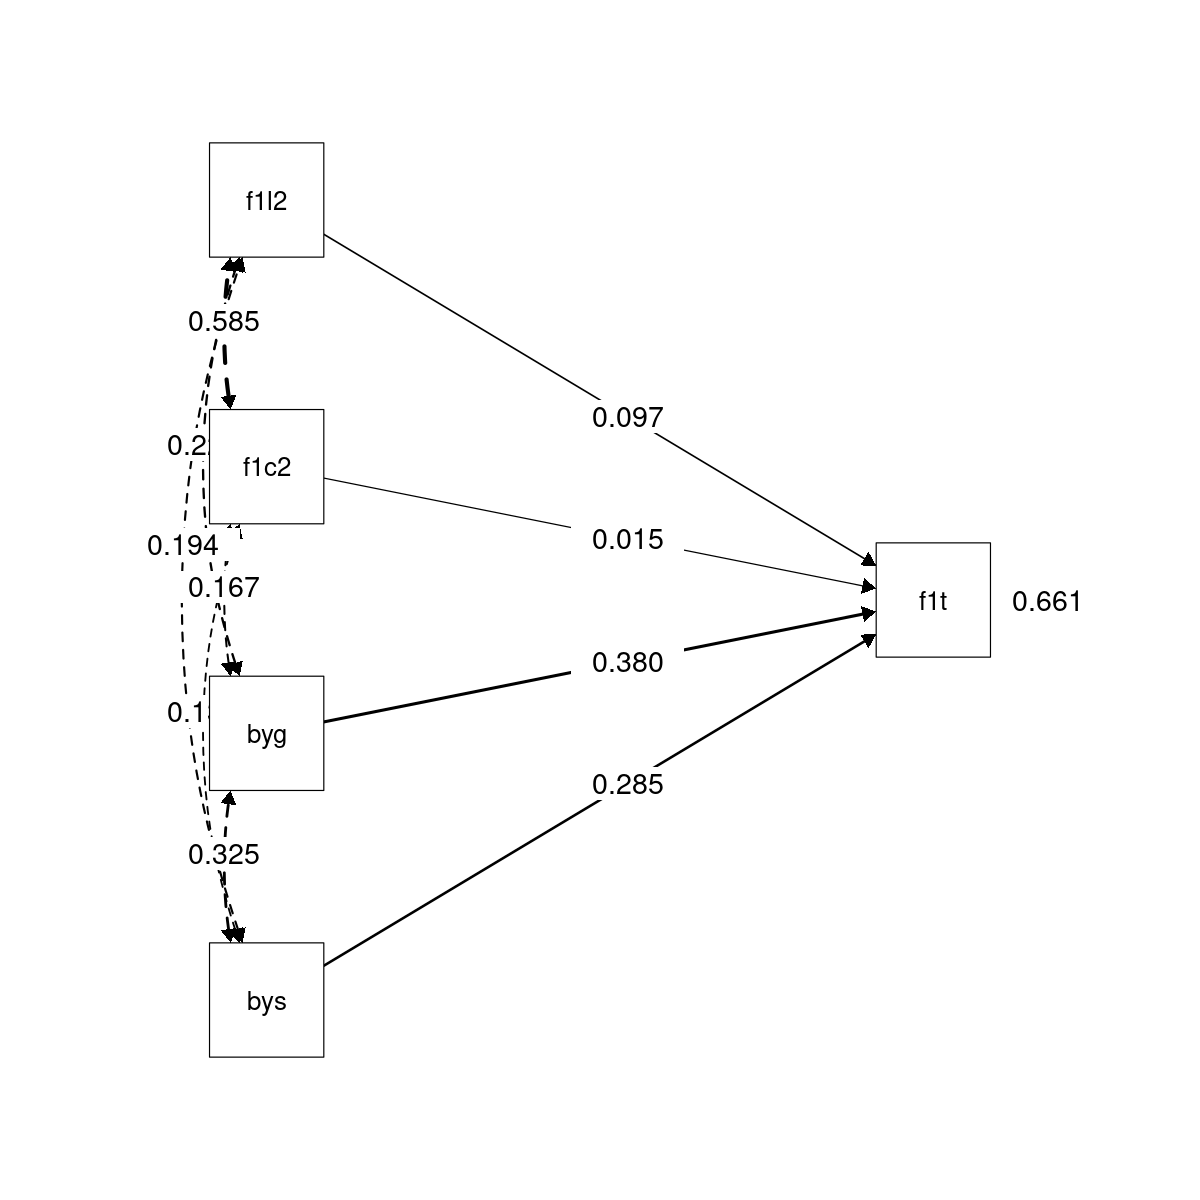

In [4]:
options(repr.plot.width=10)
options(repr.plot.height=10)
semPaths(m1,
         rotation=2,
         layout="tree2",
         what="std",
         posCol="black",
         edge.width=0.5,
         edge.label.cex=1.5,
         style="Lisrel",
         edge.label.position=0.55,
         sizeMan=9,
         nDigits = 3,
         edge.color="black", trans=1)

In [5]:
fitted(m1)

,f1txhstd,byses,bygrads,f1cncpt2,f1locus2
f1txhstd,97.201713,3.23293743,3.57173591,1.13359266,1.50075086
byses,3.232937,0.58165682,0.18064371,0.06716102,0.09101265
bygrads,3.571736,0.18064371,0.52983264,0.08094069,0.10212455
f1cncpt2,1.133593,0.06716102,0.08094069,0.44325654,0.23948097
f1locus2,1.500751,0.09101265,0.10212455,0.23948097,0.37754282


In [6]:
cov(dt, use="complete.obs")

,f1txhstd,byses,bygrads,f1cncpt2,f1locus2
f1txhstd,97.311421,3.23658635,3.57576722,1.13487211,1.50244471
byses,3.236586,0.58231332,0.18084760,0.06723683,0.09111537
bygrads,3.575767,0.18084760,0.53043065,0.08103204,0.10223982
f1cncpt2,1.134872,0.06723683,0.08103204,0.44375683,0.23975126
f1locus2,1.502445,0.09111537,0.10223982,0.23975126,0.37796894


### Sequential

In [7]:
m2 <- sem("f1txhstd ~ byses + bygrads + f1cncpt2 + f1locus2
           f1locus2 ~ f1cncpt2 + bygrads + byses
           f1cncpt2 ~ bygrads + byses
           bygrads  ~ byses", data=dt)
print(summary(m2, rsquare=TRUE, standardized=TRUE))

lavaan 0.6-12 ended normally after 1 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        14

  Number of observations                           887

Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  f1txhstd ~                                                            
    byses             3.690    0.377    9.800    0.000    3.690    0.285
    bygrads           5.150    0.398   12.947    0.000    5.150    0.380
    f1cncpt2          0.218    0.499    0.437  

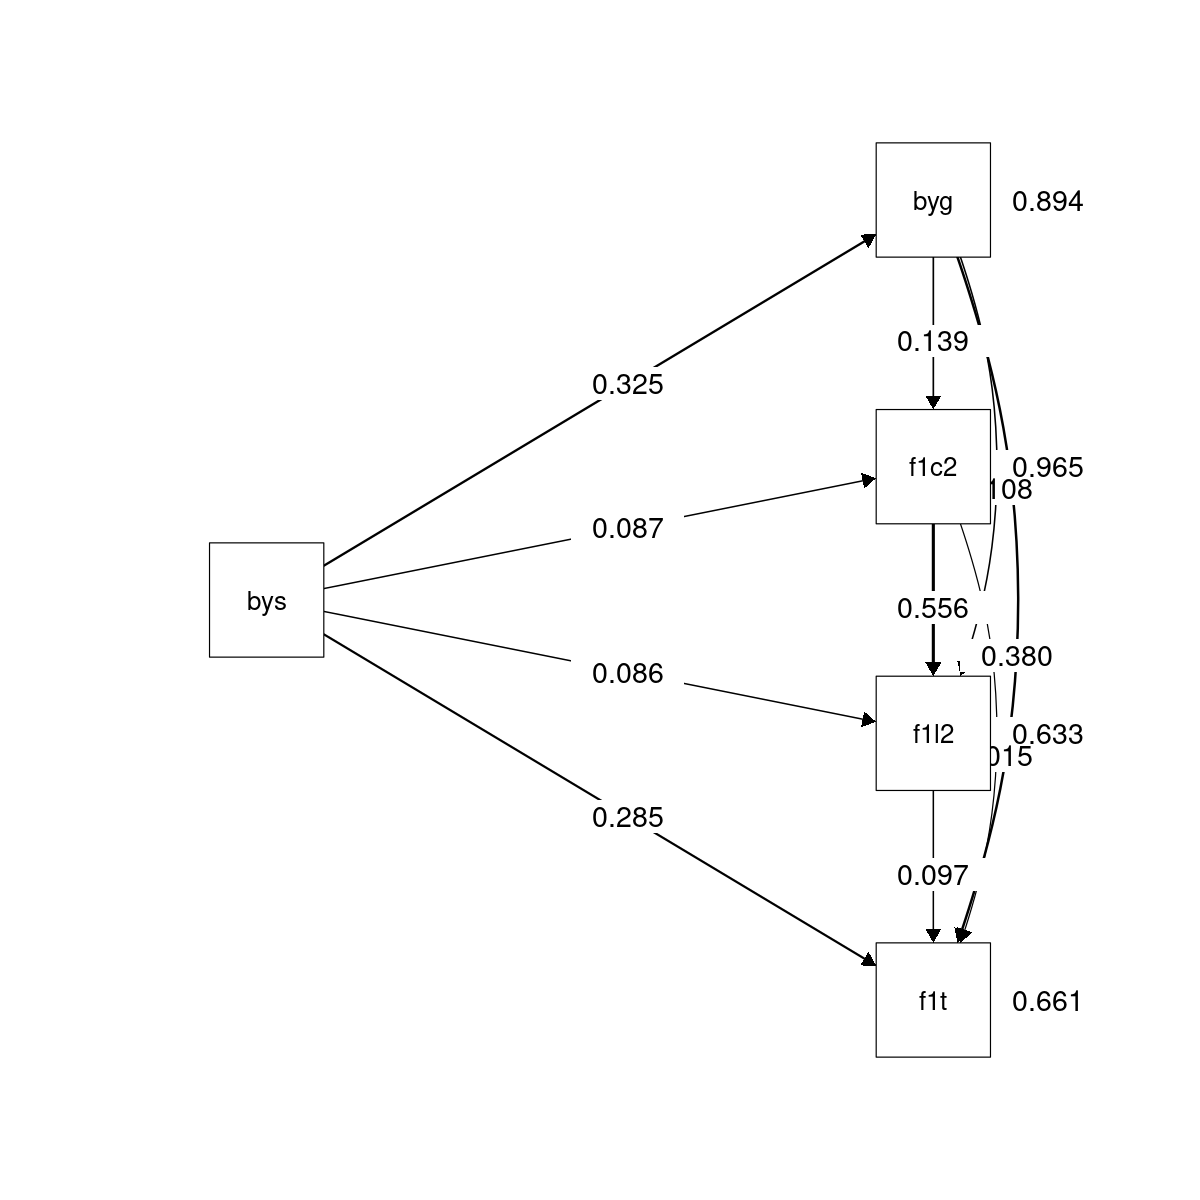

In [278]:
semPaths(m2,
         rotation=2,
         layout="tree2",
         what="std",
         posCol="black",
         edge.width=0.5,
         edge.label.cex=1.5,
         style="Lisrel",
         edge.label.position=0.55,
         sizeMan=9,
         nDigits = 3,
         edge.color="black", trans=1)

In [9]:
fitted(m2)

,f1txhstd,f1locus2,f1cncpt2,bygrads,byses
f1txhstd,97.201713,1.50075086,1.13359266,3.57173591,3.23293743
f1locus2,1.500751,0.37754282,0.23948097,0.10212455,0.09101265
f1cncpt2,1.133593,0.23948097,0.44325654,0.08094069,0.06716102
bygrads,3.571736,0.10212455,0.08094069,0.52983264,0.18064371
byses,3.232937,0.09101265,0.06716102,0.18064371,0.58165682


In [10]:
esteem <- 0.015 + 0.556*0.097
esteem

[1] 0.068932

In [11]:
grads <- 0.380 + 0.108*0.097 + 0.139*0.015 + 0.139*0.556*0.097
grads

[1] 0.4000575

In [12]:
ses <- 0.285 + 
       0.325*0.380 + 0.087*0.015 + 0.086*0.097 +
       0.325*0.139*0.015 + 0.325*0.108*0.097 + 0.087*0.556*0.097 +
       0.325*0.087*0.556*0.097
ses

[1] 0.4284463

In [13]:
summary(lm("f1txhstd ~ byses", data=dt))



Call:
lm(formula = "f1txhstd ~ byses", data = dt)

Residuals:
     Min       1Q   Median       3Q      Max 
-27.7303  -5.7697   0.3656   6.3801  22.8408 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  51.0899     0.2992  170.75   <2e-16 ***
byses         5.5582     0.3923   14.17   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.911 on 885 degrees of freedom
Multiple R-squared:  0.1849,	Adjusted R-squared:  0.1839 
F-statistic: 200.7 on 1 and 885 DF,  p-value: < 2.2e-16


In [14]:
m3 <- sem("f1txhstd ~ byses", data=dt)
print(summary(m3, rsquare=TRUE, standardized=TRUE))

lavaan 0.6-12 ended normally after 1 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         2

  Number of observations                           887

Model Test User Model:
                                                      
  Test statistic                                 0.000
  Degrees of freedom                                 0

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Regressions:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  f1txhstd ~                                                            
    byses             5.558    0.392   14.183    0.000    5.558    0.430

Variances:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
   .f1txhstd         79.233    3.76

# Latent variables

Goal: decompose observed variables into a true score `t` and an error `epsilon`:

\begin{eqnarray}
\mathbf{X} & = & \mathbf{t} + \mathbf{\epsilon} \\
\end{eqnarray}

## Exploratory path analysis

Exploratory path analysis proceeds by trying to find the latent variables for instance by Principal Component Analysis:

Using example from [3]

In [228]:
dat <- as.data.table(read.spss("https://stats.idre.ucla.edu/wp-content/uploads/2018/05/SAQ.sav",to.data.frame=TRUE, use.value.labels = FALSE))
dat <- dat[, .(q01, q03, q04, q05, q08, q06, q07)]

pr <- prcomp(dat)
summary(pr)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.7340 1.0279 0.8710 0.78065 0.74591 0.70983 0.64464
Proportion of Variance 0.4353 0.1530 0.1098 0.08823 0.08055 0.07295 0.06016
Cumulative Proportion  0.4353 0.5883 0.6981 0.78634 0.86689 0.93984 1.00000

In [231]:
pr$rotation[, c("PC1", "PC2")]

,PC1,PC2
q01,0.2791057,-0.2622529
q03,-0.4031826,0.4074421
q04,0.3764890,-0.2561130
q05,0.3446232,-0.2538974
q08,0.2614611,-0.1582652
q06,0.4275471,0.7142626
q07,0.4978717,0.3161293


## Confirmatory path analysis

## Model

\begin{eqnarray}
\mathbf{y} & = & \mathbf{\Lambda}\mathbf{\eta} + \mathbf{\epsilon} \\
\end{eqnarray}

### No covariance between manifest variables

In [30]:
model_4a <- 'f1 =~ q01 + q03 + q04 + q05 + q08 
             f2 =~ q06 + q07' 
m4a <- cfa(model_4a, data=dat)

In [234]:
inspect(m4a, "std")

$lambda
        f1    f2
q01  0.619 0.000
q03 -0.557 0.000
q04  0.694 0.000
q05  0.588 0.000
q08  0.498 0.000
q06  0.000 0.596
q07  0.000 0.861

$theta
    q01   q03   q04   q05   q08   q06   q07  
q01 0.617                                    
q03 0.000 0.689                              
q04 0.000 0.000 0.518                        
q05 0.000 0.000 0.000 0.654                  
q08 0.000 0.000 0.000 0.000 0.752            
q06 0.000 0.000 0.000 0.000 0.000 0.644      
q07 0.000 0.000 0.000 0.000 0.000 0.000 0.258

$psi
   f1    f2   
f1 1.000      
f2 0.676 1.000

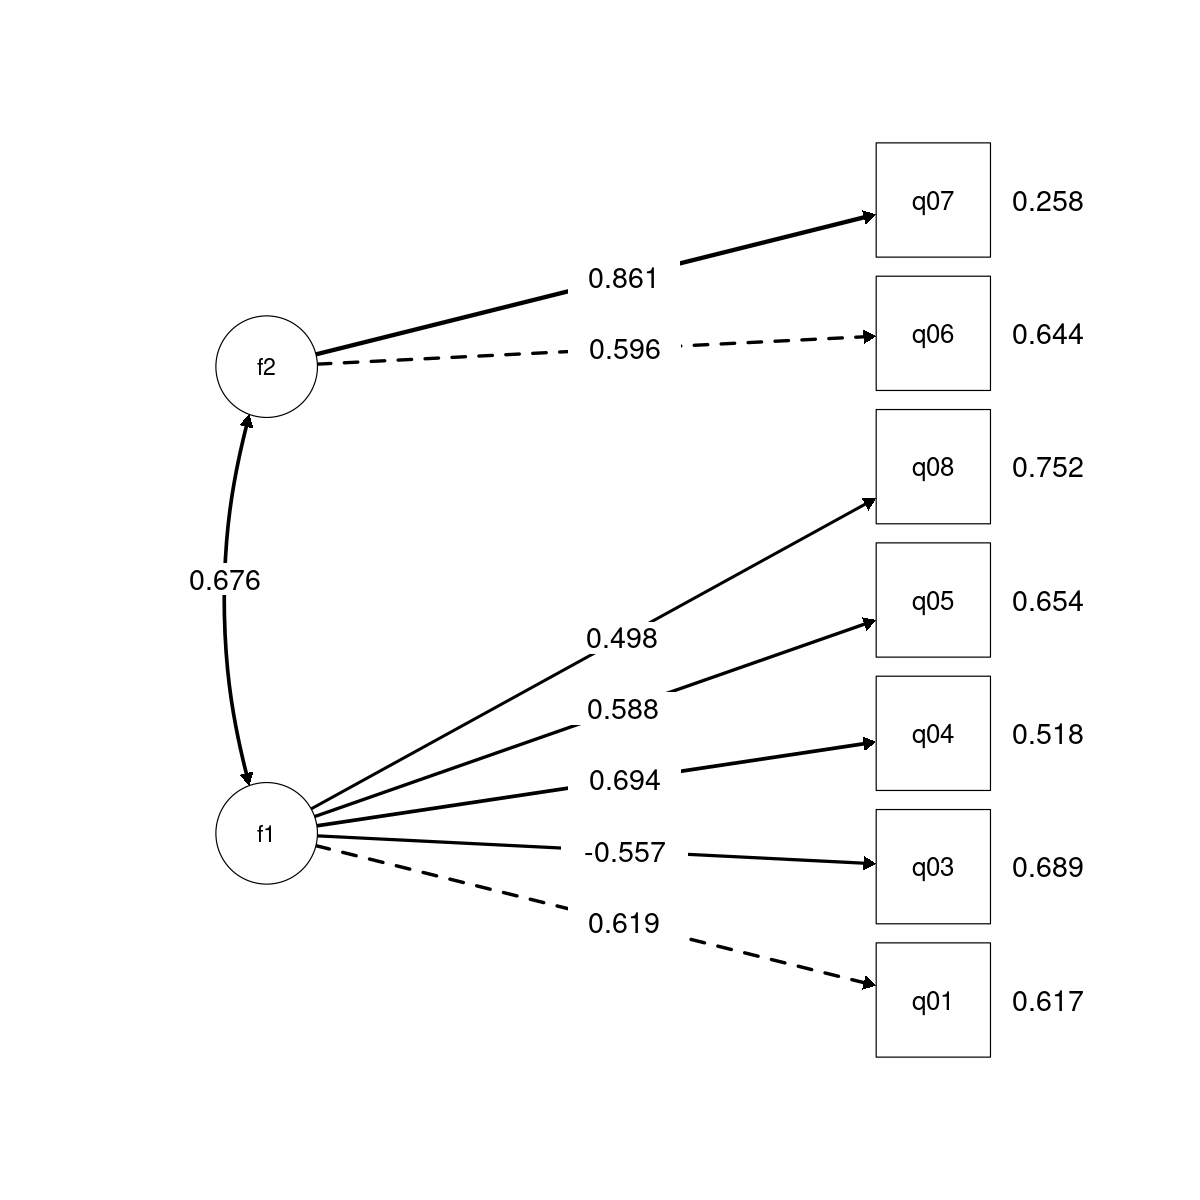

In [31]:
semPaths(m4a,
         rotation=2,
         layout="tree2",
         what="std",
         posCol="black",
         edge.width=0.5,
         edge.label.cex=1.5,
         style="Lisrel",
         edge.label.position=0.55,
         sizeMan=9,
         nDigits = 3,
         edge.color="black", trans=1)

In [25]:
print(summary(m4, fit.measures=TRUE, standardized=TRUE))

lavaan 0.6-12 ended normally after 29 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        15

  Number of observations                          2571

Model Test User Model:
                                                      
  Test statistic                                66.768
  Degrees of freedom                                13
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              3876.345
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.986
  Tucker-Lewis Index (TLI)                       0.977

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)             -23296.945
  Loglikelihood unrestricted model (H1)     -232

In [52]:
round(fitted(m4a)[["cov"]], 3)

,q01,q03,q04,q05,q08,q06,q07
q01,0.685,-0.307,0.337,0.291,0.223,0.232,0.329
q03,-0.307,1.155,-0.394,-0.340,-0.261,-0.271,-0.384
q04,0.337,-0.394,0.899,0.373,0.286,0.297,0.422
q05,0.291,-0.340,0.373,0.930,0.247,0.256,0.364
q08,0.223,-0.261,0.286,0.247,0.761,0.197,0.279
q06,0.232,-0.271,0.297,0.256,0.197,1.258,0.635
q07,0.329,-0.384,0.422,0.364,0.279,0.635,1.215


In [48]:
round(var(dat), 3)

,q01,q03,q04,q05,q08,q06,q07
q01,0.686,-0.300,0.342,0.321,0.239,0.201,0.279
q03,-0.300,1.156,-0.388,-0.322,-0.243,-0.273,-0.453
q04,0.342,-0.388,0.900,0.367,0.289,0.296,0.427
q05,0.321,-0.322,0.367,0.931,0.226,0.279,0.361
q08,0.239,-0.243,0.289,0.226,0.761,0.218,0.286
q06,0.201,-0.273,0.296,0.279,0.218,1.259,0.635
q07,0.279,-0.453,0.427,0.361,0.286,0.635,1.215


### Covariance between manifest variables

In [235]:
model_4b <- 'f1 =~ q01 + q03 + q04 + q05 + q08 
             f2 =~ q06 + q07
             q01 ~~ q03'
m4b <- cfa(model_4b, data=dat)

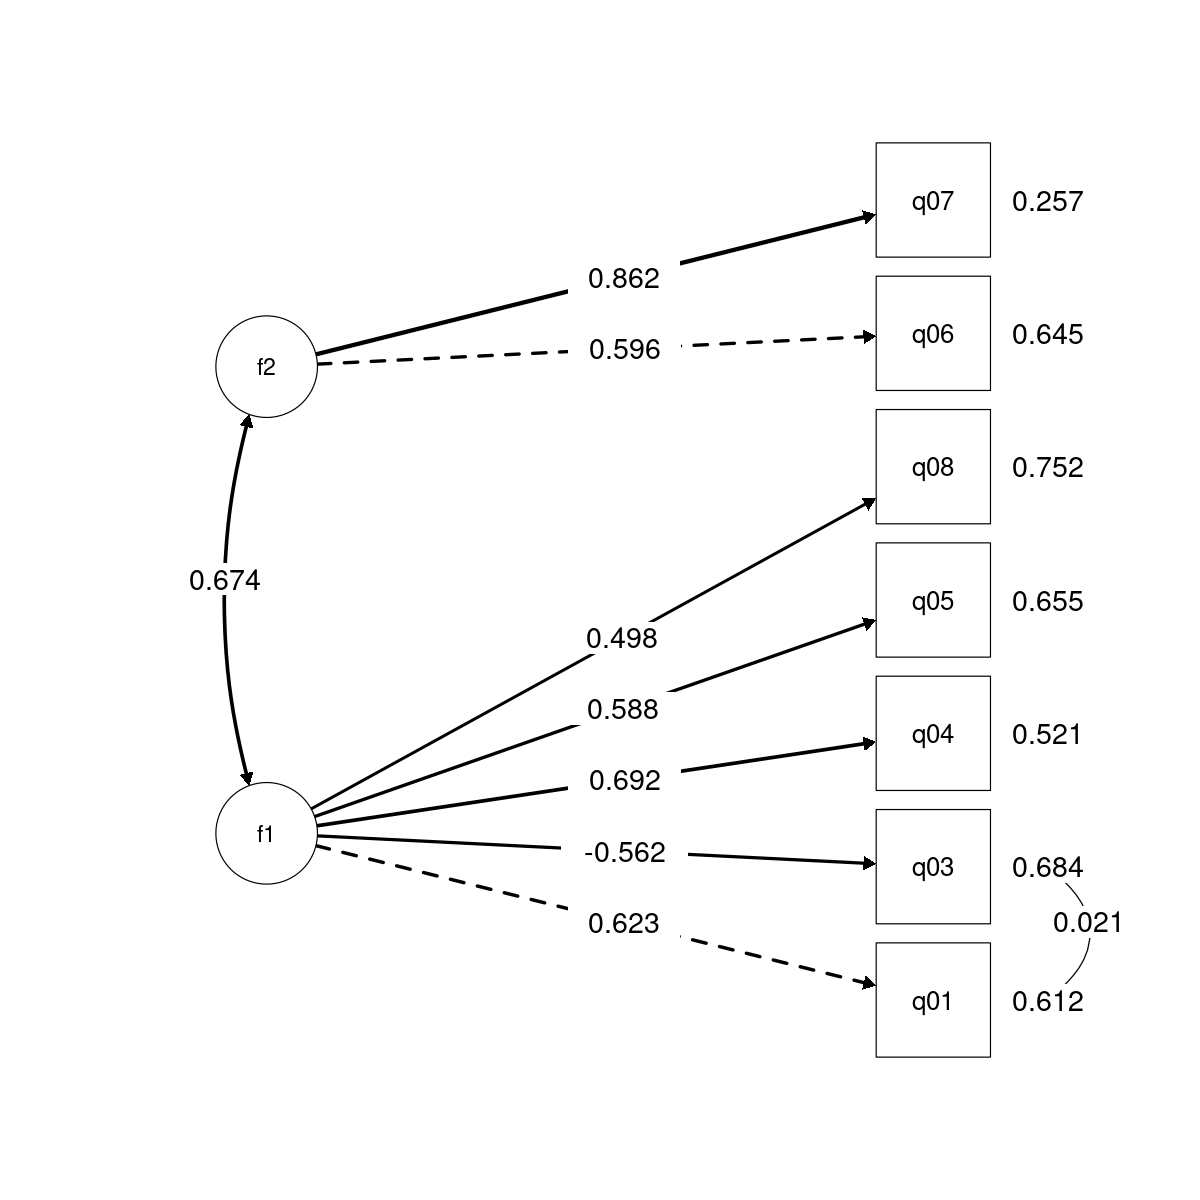

In [236]:
semPaths(m4b,
         rotation=2,
         layout="tree2",
         what="std",
         posCol="black",
         edge.width=0.5,
         edge.label.cex=1.5,
         style="Lisrel",
         edge.label.position=0.55,
         sizeMan=9,
         nDigits = 3,
         edge.color="black", trans=1)

In [241]:
## theta shows model is now estimating cov(q01, q03)
inspect(m4b, "std")$theta

,q01,q03,q04,q05,q08,q06,q07
q01,0.61150080,0.02131011,0.0000000,0.000000,0.0000000,0.0000000,0.0000000
q03,0.02131011,0.68390885,0.0000000,0.000000,0.0000000,0.0000000,0.0000000
q04,0.00000000,0.00000000,0.5207708,0.000000,0.0000000,0.0000000,0.0000000
q05,0.00000000,0.00000000,0.0000000,0.654785,0.0000000,0.0000000,0.0000000
q08,0.00000000,0.00000000,0.0000000,0.000000,0.7522605,0.0000000,0.0000000
q06,0.00000000,0.00000000,0.0000000,0.000000,0.0000000,0.6447855,0.0000000
q07,0.00000000,0.00000000,0.0000000,0.000000,0.0000000,0.0000000,0.2574488


### Getting eta values

In [54]:
head(lavPredict(m4a))

f1,f2
-0.49209642,-0.14612450
-0.46370295,-0.52192953
-0.11755563,-0.52005226
0.54244040,0.66200799
-0.29352472,0.01985241
0.02911397,0.60861478


In [164]:
## center data:
yc = scale(dat, scale=FALSE)

In [224]:
library(MASS)
Sigma_hat     <- m4a@implied$cov
Sigma_hat_inv <- lapply(Sigma_hat, MASS::ginv)[[1]]

psi <- m4a@Model@GLIST$psi

lambda <- m4a@Model@GLIST$lambda

Factor scores obtained by "classical" regression method:

\begin{eqnarray}
F & = & \mathbf{y_{centered}} (\mathbf{\Psi} \mathbf{\Lambda'} \mathbf{\Sigma^{-1}})'
\end{eqnarray}

In [225]:
fsc <- yc %*% t(psi %*% t(lambda) %*% Sigma_hat_inv)
head(fsc)

-0.49209642,-0.14612450
-0.46370295,-0.52192953
-0.11755563,-0.52005226
0.54244040,0.66200799
-0.29352472,0.01985241
0.02911397,0.60861478


In [140]:
head(lavPredict(m4a))

f1,f2
-0.49209642,-0.14612450
-0.46370295,-0.52192953
-0.11755563,-0.52005226
0.54244040,0.66200799
-0.29352472,0.01985241
0.02911397,0.60861478


## Fitting the model

This image poached from [4]:

![two factor model](sem_data/2factor_model.png)

As derived in [2]

\begin{eqnarray}
\Sigma(\theta) = Cov(\mathbf{y}) & = & Cov(\mathbf{\Lambda}\mathbf{\eta} + \mathbf{\epsilon}) \\
& = & \mathbb{E}((\mathbf{\Lambda}\mathbf{\eta} + \mathbf{\epsilon}) (\mathbf{\Lambda}\mathbf{\eta} + \mathbf{\epsilon})') \\
& = & \mathbb{E}(\mathbf{\Lambda}\mathbf{\eta}\mathbf{\eta}'\mathbf{\Lambda}' + \mathbf{\Lambda}\mathbf{\eta}\mathbf{\epsilon}' + \mathbf{\epsilon}\mathbf{\eta}'\mathbf{\Lambda}' + \mathbf{\epsilon}\mathbf{\epsilon}') \\
& = & \mathbf{\Lambda}\mathbb{E}(\mathbf{\eta}\mathbf{\eta})'\mathbf{\Lambda}' + 0 + 0 + \mathbb{E}(\mathbf{\epsilon}\mathbf{\epsilon}') \\
& = & \mathbf{\Lambda} \Psi \mathbf{\Lambda}’ + \Theta_{\epsilon} \\
\end{eqnarray}

As derived in [4]:

\begin{eqnarray}
\Sigma(\theta) = Cov(\mathbf{y}) & = & Cov(\mathbf{\tau} + \mathbf{\Lambda} \mathbf{\eta} + \mathbf{\epsilon}) \\
& = & Var(\mathbf{\tau}) + Cov(\mathbf{\Lambda} \mathbf{\eta}) + Var(\mathbf{\epsilon}) \\
& = & 0 + Cov(\mathbf{\Lambda} \mathbf{\eta}) + Var(\mathbf{\epsilon}) \\
& = & \mathbf{\Lambda} Cov(\mathbf{\eta}) \mathbf{\Lambda}’ + Var(\mathbf{\epsilon}) \\
& = & \mathbf{\Lambda} \Psi \mathbf{\Lambda}’ + \Theta_{\epsilon} \\
\end{eqnarray}

# Putting it all together

## Example

This example from [1]:

![example full](sem_data/sem_3.JPG)

# References

[1] Keith, T.Z. (2019). Multiple Regression and Beyond: An Introduction to Multiple Regression and Structural Equation Modeling (3rd ed.). Routledge. https://doi.org/10.4324/9781315162348

[2] Lambert, Ben, [Factor Analyis and SEM](https://youtube.com/playlist?list=PLwJRxp3blEvaOTZfSKXysxRmi6gXJf5gP)

[3] [Mild introduction to Structural Equation Modeling (SEM) using R](https://youtu.be/VT4Hz4XgkN8)

[4] Lin, Johnny, [Confirmatory Factor Analysis (CFA) in R with lavaan](https://stats.oarc.ucla.edu/r/seminars/rcfa/)

[5] Lin, Johnny, [Introduction to Structural Equation Modeling (SEM) in R with lavaan](https://stats.oarc.ucla.edu/r/seminars/rsem/)

[6] Sturgis, Patrick, [Structural Equation Modeling (SEM)](https://youtube.com/playlist?list=PLzv58M2GAfm4CF5-7GGDYStx9SzyhFmgK)